In [3]:
from pathlib import Path
import random
import os
from importlib import reload

import warnings
# Ignore PyTorch's KLDivLoss warning
warnings.simplefilter("ignore", category=UserWarning, lineno=2949)

import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import torch
from tqdm.auto import tqdm

In [4]:
from utils.config import BASE_PATH, SPEC_DIR
from utils.data_handling import metadata_df

class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
label2name = dict(enumerate(class_names))
name2label = {v:k for k, v in label2name.items()}

metadata = metadata_df("train")
display(metadata.head(2))

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec_npy_path,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,data/train_eegs/1628180742.parquet,data/train_spectrograms/353733.parquet,data/spectrograms_npy/train_spectrograms/35373...,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,data/train_eegs/1628180742.parquet,data/train_spectrograms/353733.parquet,data/spectrograms_npy/train_spectrograms/35373...,0


In [5]:
from utils import SpectrogramDataset
valid_frac = 0.1
num_unique_spectrograms = metadata.spectrogram_id.unique().shape[0]
valid_num = round(valid_frac * num_unique_spectrograms)
print(f"{num_unique_spectrograms} unique spectrograms, using {valid_num} for validation set.")

rng = np.random.default_rng(seed=4)
valid_set = rng.choice(metadata.spectrogram_id.unique(), size=valid_num, replace=False)
metadata_train = metadata[~metadata.spectrogram_id.isin(valid_set)]
metadata_valid = metadata[metadata.spectrogram_id.isin(valid_set)]
print(f"{len(metadata_train)} training items, {len(metadata_valid)} validation items.")

train_small = SpectrogramDataset(metadata_train, n_items=5000, preloaded=True)
valid_small = SpectrogramDataset(metadata_valid, n_items=1000, preloaded=True)
print(f"{len(train_small)} training items, {len(valid_small)} validation items.")

11138 unique spectrograms, using 1114 for validation set.
95346 training items, 11454 validation items.
5000 training items, 1000 validation items.


In [6]:
import torchvision
auto_tfms = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
auto_tfms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [8]:
from torchvision import transforms
manual_tfms = transforms.Compose([
    lambda x: x.unsqueeze(0).repeat(3,1,1),  # convert to RGB
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    # EffnetB0 expects size [224, 224] images. But I won't center-crop, since
    # this leaves out too much data from LL and RP.
    lambda x: torch.clamp(x, 1e-4, 1e7),  # avoid log(0) errors
    torch.log,                            # log-scale as in visualization
    lambda x: (x - x.min()) / x.max(),    # scale to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # normalization from EffnetB0 transforms
])

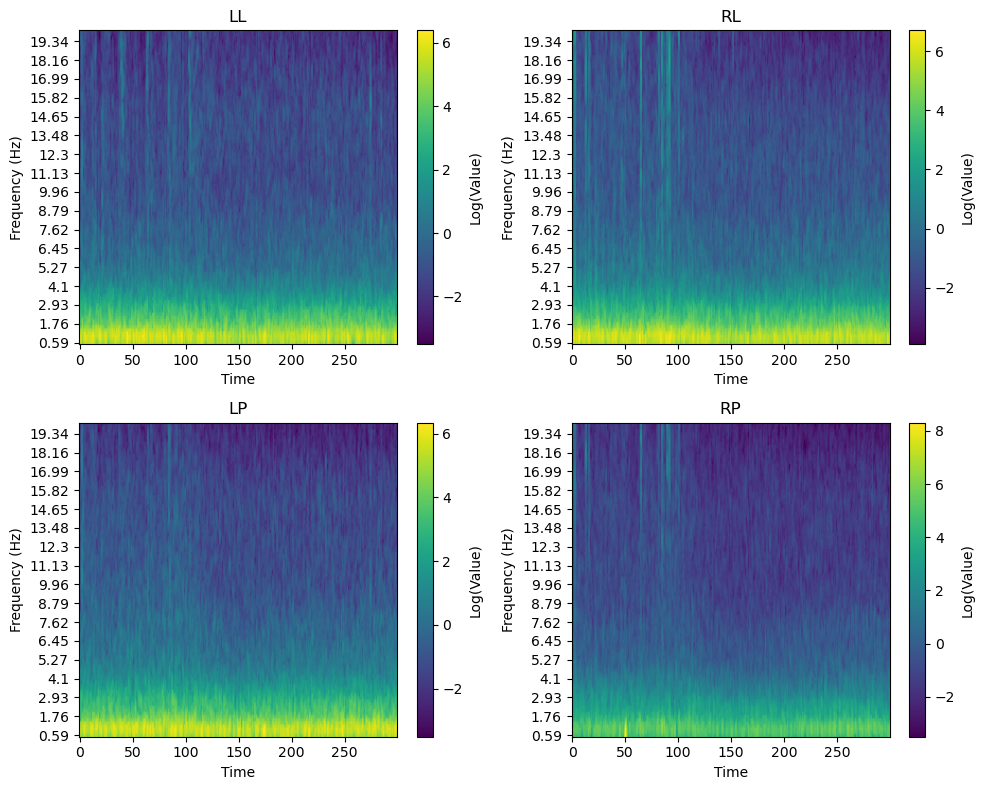

In [7]:
from utils.visualization import visualize_spectrogram
idx = random.randint(0, len(train_small))
orig = train_small[idx][0]
visualize_spectrogram(orig)

In [10]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_small, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_small, batch_size=32)

In [14]:
import utils.models
reload(utils.models)
from utils.training import Trainer
from utils.models import Spectrogram_EfficientNet
from utils.config import DEVICE

model = Spectrogram_EfficientNet(frozen=False).to(DEVICE)
trainer = Trainer(model, train_loader, valid_loader)



In [15]:
trainer.time_train_step(1000)
trainer.time_val_step(1000)

Trained on 1000 batches in 59.69s.
Predicted on 1000 validation batches in 25.31s.


1000

Training:   0%|          | 0/10640 [00:00<?, ?it/s]

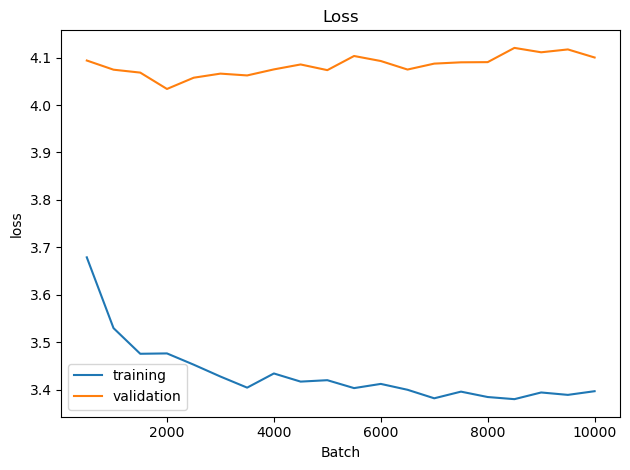

In [46]:
model = Spectrogram_EfficientNet().to(DEVICE)
trainer = Trainer(model, train_loader, valid_loader)

trainer.train_eval_loop(10_000, 500, 500)
trainer.plot_metrics()

Training:   0%|          | 0/10640 [00:00<?, ?it/s]

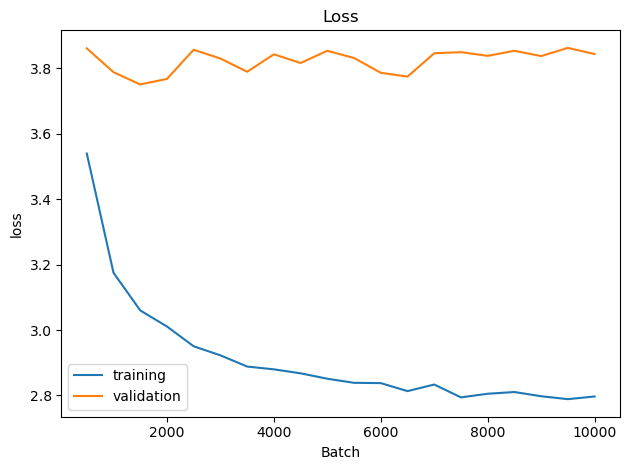

In [16]:
# Unfrozen
model = Spectrogram_EfficientNet(frozen=False).to(DEVICE)
trainer = Trainer(model, train_loader, valid_loader)

trainer.train_eval_loop(10_000, 500, 500)
trainer.plot_metrics()

The model overfits immediately. My guess is that the training dataset is too small.

In [17]:
from utils.config import MODEL_SAVE_DIR
torch.save(model, MODEL_SAVE_DIR / "spectrogram_effnetb0_unfrozen_5000_items.pt")